In [8]:
import gc
import os
from dotenv import load_dotenv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm_notebook
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight

tqdm_notebook.pandas()

time: 4.45 ms (started: 2024-01-02 16:20:25 +08:00)


In [7]:
%load_ext autotime
load_dotenv()

HF_TOKEN = os.getenv("HF_TOKEN")

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.05 ms (started: 2024-01-02 16:19:38 +08:00)


In [3]:
device = "mps"

time: 1.8 ms (started: 2024-01-02 16:16:52 +08:00)


In [11]:
data_df = pd.read_parquet("dataset/train_df.parquet")
data_df["sentence"] = data_df["title"] + " || " + data_df["content"]
data_df["stratified_col"] = data_df["impact_length_idx"].astype(str) + data_df["language"]
sentences = list(data_df["sentence"])

time: 119 ms (started: 2024-01-02 16:21:21 +08:00)


In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', token=HF_TOKEN)
model = BertModel.from_pretrained("bert-base-multilingual-cased", token=HF_TOKEN).to(device)

time: 2.29 s (started: 2024-01-02 16:20:58 +08:00)


In [24]:
batch_size = 64

data_loader = DataLoader(sentences, batch_size=batch_size, shuffle=True)

embeddings = []
with torch.no_grad():
    for batch in data_loader:
        encoded_inputs = tokenizer.batch_encode_plus(
          batch,
          padding='max_length',
          truncation=True,
          return_tensors='pt'
        )
        encoded_inputs = {key: val.to(model.device) for key, val in encoded_inputs.items()}

        output = model(**encoded_inputs)
        hidden_states = output.last_hidden_state
        cls_embeddings = hidden_states[:, 0, :]
        embeddings.extend(cls_embeddings.detach().cpu().numpy())

        gc.collect()
        torch.mps.empty_cache()

In [20]:
data_df["embedding"] = embeddings

time: 8.49 ms (started: 2024-01-02 16:29:21 +08:00)


In [21]:
def upsample_train_dataset(df):
    class_counts = df['stratified_col'].value_counts()
    majority_class = class_counts.idxmax()
    majority_count = class_counts.max()

    upsampled_dataframes = []

    for class_label in df['stratified_col'].unique():
        class_df = df[df['stratified_col'] == class_label]

        if class_label == majority_class:
            upsampled_dataframes.append(class_df)
        else:
            upsampled_class_df = resample(class_df,
                                          replace=True,
                                          n_samples=majority_count,
                                          random_state=314)
            upsampled_dataframes.append(upsampled_class_df)

    upsampled_df = pd.concat(upsampled_dataframes)

    upsampled_df = upsampled_df.sample(frac=1, random_state=314).reset_index(drop=True)
    return upsampled_df

time: 632 µs (started: 2024-01-02 16:29:21 +08:00)


In [22]:
accuracys = []
precisions = []
recalls = []
f1s = []
predictions = []

skf = StratifiedKFold(n_splits=5)
for train_idx, valid_idx in skf.split(data_df["embedding"],
                                      data_df["stratified_col"]):
  train_df = data_df.loc[train_idx]
  valid_df = data_df.loc[valid_idx]

  resampled_train_df = upsample_train_dataset(train_df)

  X_train = np.stack(resampled_train_df["embedding"])
  y_train = np.stack(resampled_train_df["impact_length_idx"])
  X_valid = np.stack(valid_df["embedding"])
  y_valid = np.stack(valid_df["impact_length_idx"])

  lr = LogisticRegression(random_state=314,
                          C = 0.005,
                          max_iter=500).fit(X_train, y_train)

  y_pred = lr.predict(X_valid)
  accuracy = lr.score(X_valid, y_valid)
  precision = precision_score(y_valid, y_pred, average='weighted')
  recall = recall_score(y_valid, y_pred, average='weighted')
  f1 = f1_score(y_valid, y_pred, average='weighted')

  accuracys.append(accuracy)
  precisions.append(precision)
  recalls.append(recall)
  f1s.append(f1)

print("accuracy:", np.mean(accuracys))
print("precision:",np.mean(precisions))
print("recall:", np.mean(recalls))
print("f1:", np.mean(f1s))

accuracy: 0.31679531469286404
precision: 0.3293002019832011
recall: 0.31679531469286404
f1: 0.31732918397689874
time: 3.12 s (started: 2024-01-02 16:29:21 +08:00)


Text(0.5, 1.0, 'Confusion Matrix')

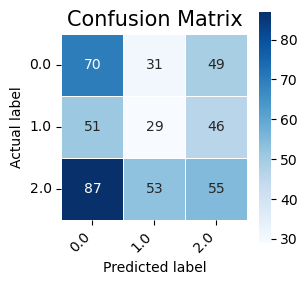

time: 1.42 s (started: 2024-01-02 16:29:24 +08:00)


In [23]:
cm = confusion_matrix(y_valid, y_pred)

plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt="0", linewidths=.5,
            square = True, cmap = "Blues");
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.xticks(ticks=np.arange(3) + 0.5, labels=lr.classes_, rotation=45, ha='right')
plt.yticks(ticks=np.arange(3) + 0.5, labels=lr.classes_, rotation=0)

all_sample_title = "Confusion Matrix"
plt.title(all_sample_title, size = 15)